# 03 Objektfläche

Hier sehen wir uns mal die Objektfläche an.

In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import pandas as pd

from plotting_tools.colormaps import enhanced_colormap2
emap = enhanced_colormap2(vmin=210,vmed1=240,vmed2=270,vmax=300)

import sys
sys.path.append("/vols/satellite/home/lenk/utils/tracking")
import object_tracking as ot

import datetime as dt

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
def time2index(start_time,time,freq):
    start_hour = int(start_time.split(":")[0])
    start_minute = int(start_time.split(":")[1])
    
    start_time = start_hour * 60 + start_minute
    
    time_hour = int(time.split(":")[0])
    time_minute = int(time.split(":")[1]) 
    
    time = time_hour * 60 + time_minute
    
    time_diff = time - start_time
    
    time_idx = time_diff / freq
    
    return int(time_idx)

In [3]:
start_idx = time2index("12:00",'13:15',5)
end_idx = time2index("12:00",'14:00',5)

In [4]:
data_folder = "/vols/satellite/home/lenk/proj/2019-12_HRV-Paper/"

In [5]:
sat_data = xr.open_dataset("{}/msg2-20130618-l15msg.nc".format(data_folder))

In [13]:
object_mask = xr.open_dataset("/vols/satellite/home/lenk/proj/2019-12_HRV-Paper/object_mask.nc")

In [7]:
object_mask

<xarray.Dataset>
Dimensions:             (time: 9, x: 51, y: 101)
Coordinates:
  * time                (time) datetime64[ns] 2013-06-18T13:15:00 ... 2013-06-18T13:55:00
    lon                 (x, y) float64 ...
    lat                 (x, y) float64 ...
Dimensions without coordinates: x, y
Data variables:
    object_mask_240_05  (time, x, y) uint8 ...
    object_mask_240_07  (time, x, y) uint8 ...
    object_mask_230_05  (time, x, y) uint8 ...
    object_mask_230_07  (time, x, y) uint8 ...

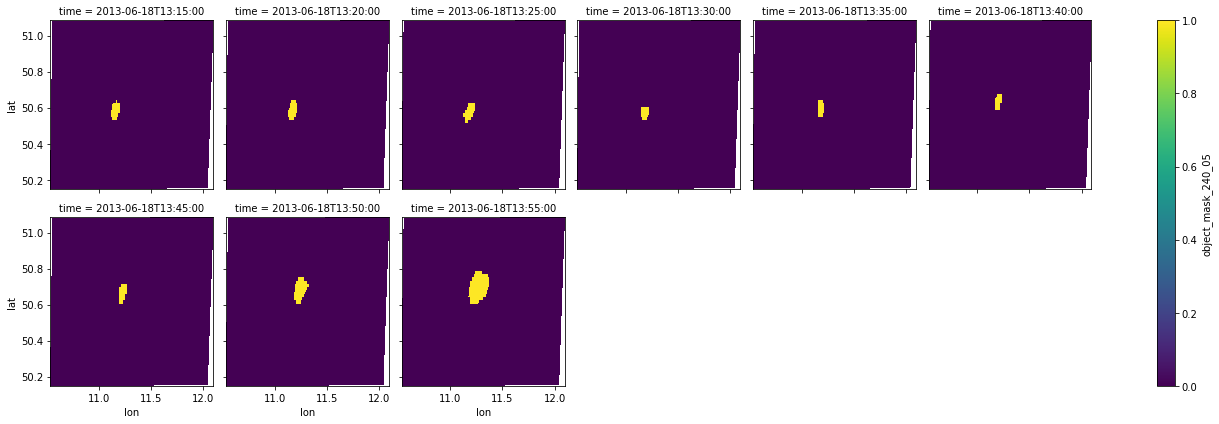

In [8]:
object_mask.object_mask_240_05.plot(x='lon',y='lat',col='time',col_wrap=6)

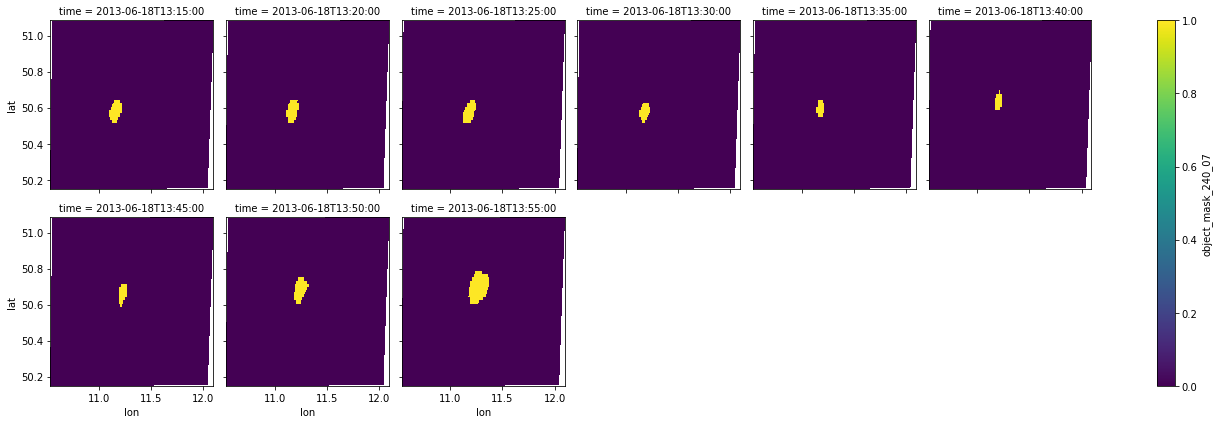

In [9]:
object_mask.object_mask_240_07.plot(x='lon',y='lat',col='time',col_wrap=6)

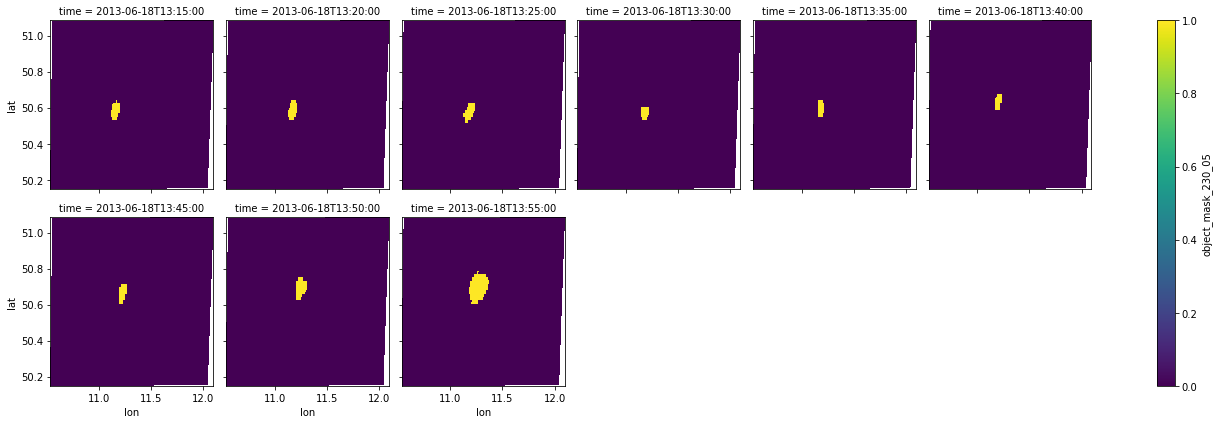

In [10]:
object_mask.object_mask_230_05.plot(x='lon',y='lat',col='time',col_wrap=6)

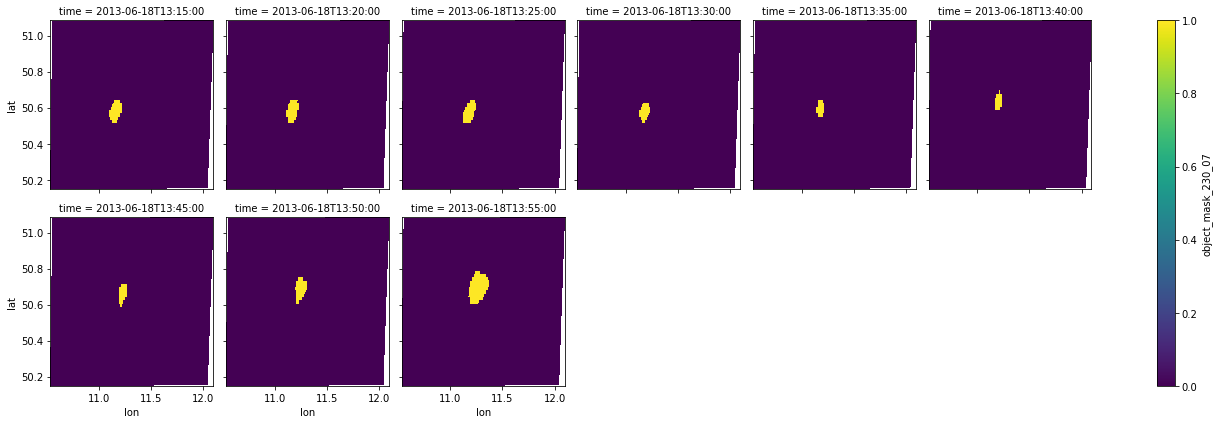

In [14]:
object_mask.object_mask_230_07.plot(x='lon',y='lat',col='time',col_wrap=6)

In [15]:
cpp_hr_data = xr.open_dataset("/vols/satellite/home/lenk/proj/2019-12_HRV-Paper/msg2-20130618-l2cpphr.nc")
cpp_lr_data = xr.open_dataset("/vols/satellite/home/lenk/proj/2019-12_HRV-Paper/msg2-20130618-l2cpplr.nc")

Hartwig interpoliert die Matrizen immer in Nord-Süd-Richtung, um sie symmetrisch zu machen. Das sollten wir wahrscheinlich auch machen, um ungfähr Pixel mit einer Fläche von 1&thinsp;km<sup>2</sup> zu bekommen.

In [16]:
test = sat_data.ir108.data[0].copy()

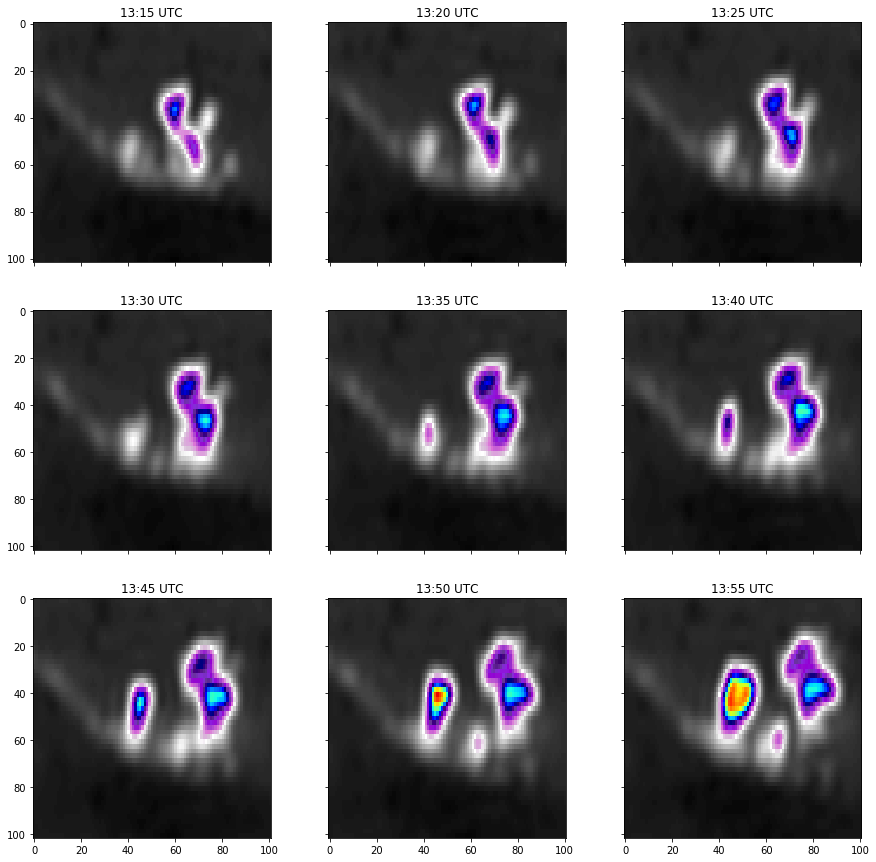

In [17]:
fig,ax = plt.subplots(3,3,figsize=(15,15),sharex=True, sharey=True)
axs = ax.ravel()

for i, ir in enumerate(sat_data.ir108.data[start_idx:end_idx]):
    axs[i].imshow(ir.repeat(2, axis=0),vmin=210,vmax=300,cmap=emap)
    axs[i].set_title(pd.Timestamp(sat_data.time.data[start_idx:end_idx][i]).strftime("%H:%M UTC"))

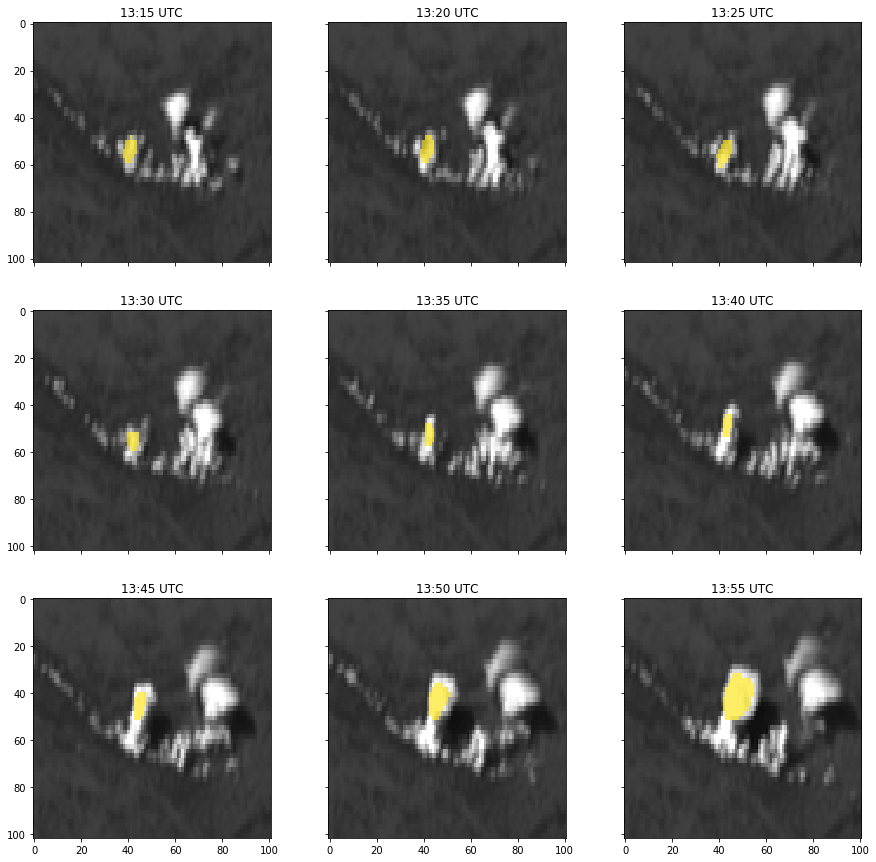

In [18]:
fig,ax = plt.subplots(3,3,figsize=(15,15),sharex=True, sharey=True)
axs = ax.ravel()

for i, h in enumerate(sat_data.hrv.data[start_idx:end_idx]):
    axs[i].imshow(h.repeat(2, axis=0),vmin=0,vmax=0.8,cmap='gray')
    axs[i].imshow(np.ma.masked_less(object_mask.object_mask_240_05.data[i].repeat(2, axis=0).repeat(1, axis=1),1),
                  alpha=0.7,cmap='viridis_r')
    axs[i].set_title(pd.Timestamp(sat_data.time.data[start_idx:end_idx][i]).strftime("%H:%M UTC"))

Text(0.01, 0.5, 'latitutde / °N')

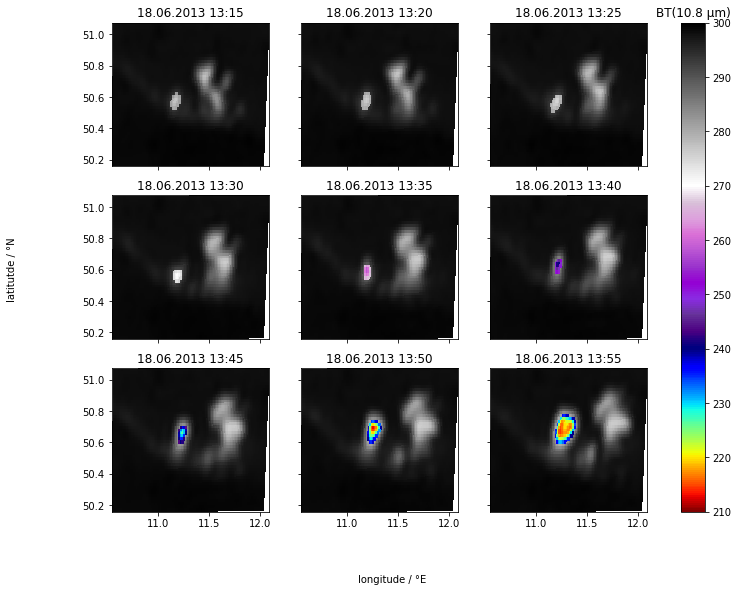

In [560]:
fig,ax = plt.subplots(3,3,figsize=(12,9),sharex=True,sharey=True)
axs=ax.ravel()

for i,ir in enumerate(sat_data.ir108.data[start_idx:end_idx]):
    ir_masked = np.ma.masked_where(object_mask.object_mask.data[i]!=1,ir)
    
    axs[i].pcolormesh(sat_data.lon.data,sat_data.lat.data,ir,vmin=210,vmax=300,cmap='gray_r')
    p = axs[i].pcolormesh(sat_data.lon.data,
                          sat_data.lat.data,
                          ir_masked,vmin=210,vmax=300,cmap=emap)
    axs[i].set_title(pd.Timestamp(sat_data.time.data[start_idx:end_idx][i]).strftime("%d.%m.%Y %H:%M"))
    
cbar = fig.colorbar(p, ax=ax.flat)
cbar.ax.set_title(u'BT(10.8 µm)')

# Make common axis labels
fig.text(0.45, 0.02,u'longitude / °E', va='center', ha='center')
fig.text(0.01, 0.5, u'latitutde / °N', va='center', ha='center', rotation='vertical')

Text(0.5, 1.0, 'COT')

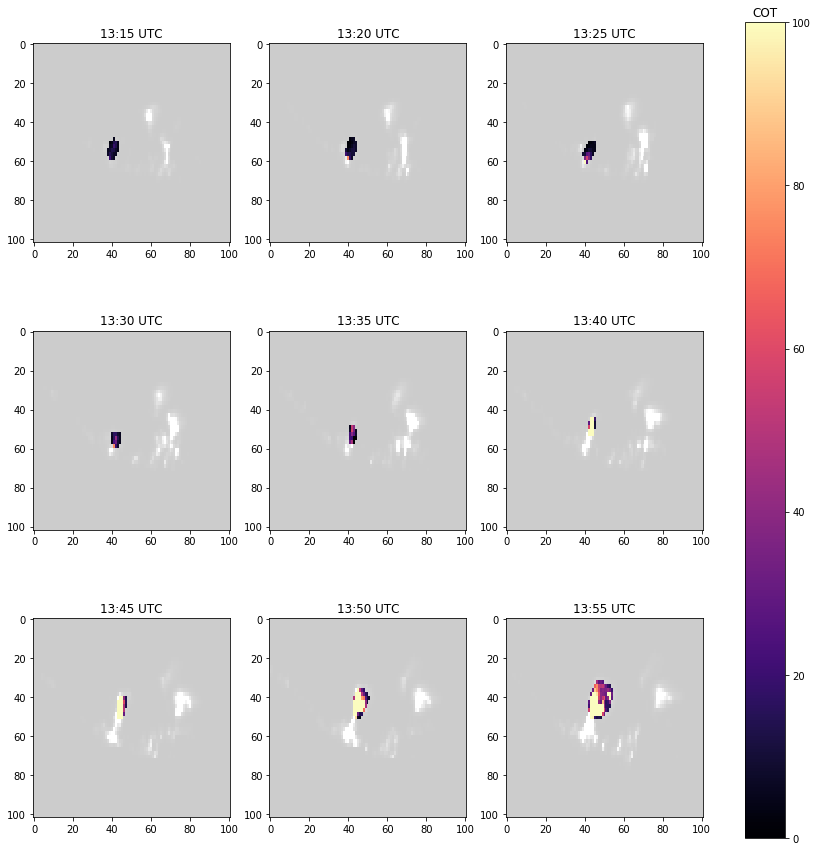

In [562]:
fig,ax = plt.subplots(3,3,figsize=(15,15))
axs = ax.ravel()

for i, c in enumerate(cpp_hr_data.cot.data[start_idx:end_idx]):
    c_masked = np.ma.masked_where(object_mask.object_mask.data[i].repeat(2,axis=0).repeat(1,axis=1)!=1,
                                  c.repeat(2, axis=0).repeat(1, axis=1))
    axs[i].imshow(c.repeat(2, axis=0).repeat(1, axis=1),
                  vmin=0,vmax=100,cmap='gray',alpha=0.2)
    p = axs[i].imshow(c_masked,cmap='magma',vmin=0,vmax=100)
    axs[i].set_title(pd.Timestamp(sat_data.time.data[start_idx:end_idx][i]).strftime("%H:%M UTC"))
    
cbar = fig.colorbar(p, ax=ax.flat)
cbar.ax.set_title(u'COT')

Text(0.01, 0.5, 'latitutde / °N')

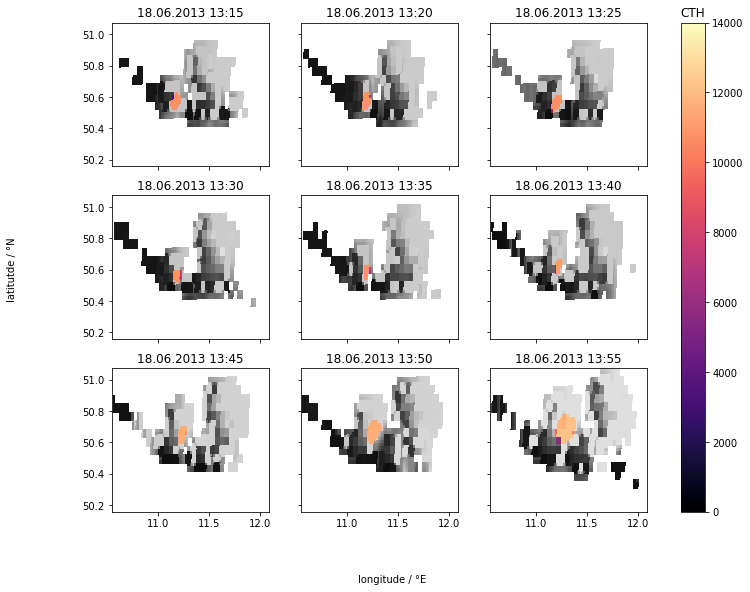

In [563]:
fig,ax = plt.subplots(3,3,figsize=(12,9),sharex=True,sharey=True)
axs=ax.ravel()

for i,c in enumerate(cpp_hr_data.cth.data[start_idx:end_idx]):
    c_masked = np.ma.masked_where(object_mask.object_mask.data[i]!=1,c)
    
    axs[i].pcolormesh(sat_data.lon.data,sat_data.lat.data,c,vmin=0,vmax=14000,cmap='gray')
    p = axs[i].pcolormesh(sat_data.lon.data,
                          sat_data.lat.data,
                          c_masked,vmin=0,vmax=14000,cmap='magma')
    axs[i].set_title(pd.Timestamp(sat_data.time.data[start_idx:end_idx][i]).strftime("%d.%m.%Y %H:%M"))
    
cbar = fig.colorbar(p, ax=ax.flat)
cbar.ax.set_title(u'CTH')

# Make common axis labels
fig.text(0.45, 0.02,u'longitude / °E', va='center', ha='center')
fig.text(0.01, 0.5, u'latitutde / °N', va='center', ha='center', rotation='vertical')

Das verdoppelt die Pixelzahl in Nord-Süd-Richtung ohne die Werte zu verändern, sodass die Pixel jetzt in x- und y-Richtung ungefähr gleich groß sind.

Als nächstes extrahieren wir die Pixelwerte der so interpolierten Felder.

In [36]:
cpp_vars = list(cpp_hr_data.data_vars)[1:13]

In [37]:
fields = list(sat_data.data_vars)[:12] + cpp_vars

In [38]:
fields

['vis006',
 'vis008',
 'ir016',
 'ir039',
 'wv062',
 'wv073',
 'ir087',
 'ir097',
 'ir108',
 'ir120',
 'ir134',
 'hrv',
 'cldmask',
 'cot',
 'cot_unc',
 'cre',
 'cre_unc',
 'cwp',
 'cwp_unc',
 'cph',
 'cph_pavo',
 'cth',
 'ctt',
 'ctp']

In [39]:
start_tidx = start_idx
end_tidx = end_idx

In [40]:
plt.imshow(object_mask.object_mask[0].data)

AttributeError: 'Dataset' object has no attribute 'object_mask'

In [41]:
object_data = []
field = []
tidx = []
resolution = []
masking = []

for thr in [240,230]:
    for sp in [5,7]:
        for i, obj in enumerate(object_mask["object_mask_{}_{:02d}".format(thr,sp)].data):
            obj_locations = np.where(obj.repeat(2, axis=0).repeat(1, axis=1)==1)

            for f in fields:
                if f in sat_data.data_vars:
                    data = sat_data[f].data[start_tidx:end_tidx][i].repeat(2, axis=0).repeat(1, axis=1)[obj_locations]

                    object_data.extend(data)
                    field.extend([f]*len(obj_locations[0]))
                    tidx.extend([pd.Timestamp(sat_data.time.data[start_tidx:end_tidx][i]).strftime("%H:%M")]*len(obj_locations[0]))
                    masking.extend(["{}_{:02d}".format(thr,sp)]*len(obj_locations[0]))
                    if f == 'hrv':
                        resolution.extend(['SEVIRI HRV']*len(obj_locations[0]))
                    else:
                        resolution.extend(['SEVIRI standard']*len(obj_locations[0]))
                else:
                    data_lr = cpp_lr_data[f].data[start_tidx:end_tidx][i].repeat(2, axis=0).repeat(1, axis=1)[obj_locations]
                    resolution.extend(['SEVIRI standard']*len(obj_locations[0]))
                    object_data.extend(data_lr)
                    field.extend([f]*len(obj_locations[0]))
                    tidx.extend([pd.Timestamp(sat_data.time.data[start_tidx:end_tidx][i]).strftime("%H:%M")]*len(obj_locations[0]))   
                    masking.extend(["{}_{:02d}".format(thr,sp)]*len(obj_locations[0]))

                    data_hr = cpp_hr_data[f].data[start_tidx:end_tidx][i].repeat(2, axis=0).repeat(1, axis=1)[obj_locations]
                    resolution.extend(['SEVIRI HRV']*len(obj_locations[0]))
                    object_data.extend(data_hr)
                    field.extend([f]*len(obj_locations[0]))
                    tidx.extend([pd.Timestamp(sat_data.time.data[start_tidx:end_tidx][i]).strftime("%H:%M")]*len(obj_locations[0])) 
                    masking.extend(["{}_{:02d}".format(thr,sp)]*len(obj_locations[0]))

In [33]:
"{}_{:02d}".format(240,5)

'240_05'

In [42]:
object_data_df = pd.DataFrame({'value':object_data,'field':field,'time':tidx,'resolution':resolution,'masking':masking})

In [43]:
object_data_df.to_csv("/vols/satellite/home/lenk/proj/2019-12_HRV-Paper/object_data.csv",index=False,float_format="%3f")

In [44]:
object_data_df.head()

,value,field,time,resolution,masking
0,0.2980,vis006,13:15,SEVIRI standard,240_05
1,0.2980,vis006,13:15,SEVIRI standard,240_05
2,0.3422,vis006,13:15,SEVIRI standard,240_05
3,0.3730,vis006,13:15,SEVIRI standard,240_05
4,0.3829,vis006,13:15,SEVIRI standard,240_05


In [45]:
sns.set_style("ticks")
sns.set_context("paper")

In [46]:
ir108_df = object_data_df[object_data_df.field=='ir108']

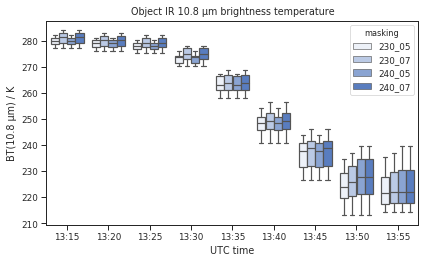

In [48]:
fig,ax = plt.subplots(1,1,figsize=(6,3.75))
sns.boxplot(x='time',y='value',data=ir108_df,ax=ax,color=sns.color_palette('muted')[0],hue='masking')
ax.set_ylabel("BT(10.8 µm) / K")
ax.set_xlabel("UTC time")
ax.set_title("Object IR 10.8 µm brightness temperature")
plt.tight_layout()
plt.savefig("{}/time_series_ir108.pdf".format(data_folder))

In [50]:
hrv_df = object_data_df[object_data_df.field=='hrv']

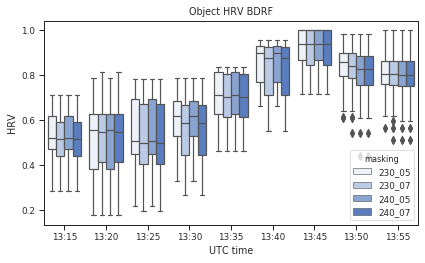

In [51]:
fig,ax = plt.subplots(1,1,figsize=(6,3.75))
sns.boxplot(x='time',y='value',data=hrv_df,ax=ax,color=sns.color_palette('muted')[0],hue='masking')
ax.set_ylabel("HRV")
ax.set_xlabel("UTC time")
ax.set_title("Object HRV BDRF")
plt.tight_layout()
plt.savefig("{}/time_series_hrv.pdf".format(data_folder))

In [52]:
cth_df = object_data_df[object_data_df.field=='cth']

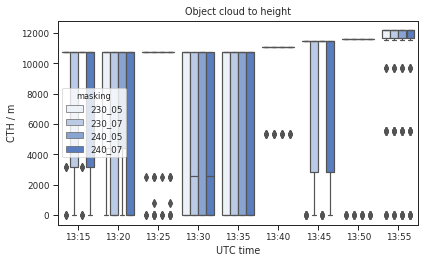

In [53]:
fig,ax = plt.subplots(1,1,figsize=(6,3.75))
sns.boxplot(x='time',y='value',data=cth_df,ax=ax,color=sns.color_palette('muted')[0],hue='masking')
ax.set_ylabel("CTH / m")
ax.set_xlabel("UTC time")
ax.set_title("Object cloud to height")
plt.tight_layout()
plt.savefig("{}/time_series_cth.pdf".format(data_folder))

In [54]:
cot_df = object_data_df[object_data_df.field=='cot']

In [55]:
cot_df.head()

,value,field,time,resolution,masking
700,2.93,cot,13:15,SEVIRI standard,240_05
701,2.93,cot,13:15,SEVIRI standard,240_05
702,4.49,cot,13:15,SEVIRI standard,240_05
703,4.34,cot,13:15,SEVIRI standard,240_05
704,4.58,cot,13:15,SEVIRI standard,240_05


In [56]:
object_mask.close()

In [57]:
# mehr Platz zwischen Boxen, https://stackoverflow.com/questions/51105226/seaborn-boxplot-individual-box-spacing
def _reduce_box_width(artist, factor=.5):
    vertices = artist.get_path().vertices
    artist_width = vertices[1, 0] - vertices[0, 0]
    vertices[0, 0] += artist_width * (factor/2)
    vertices[1, 0] -= artist_width * (factor/2)
    vertices[2, 0] -= artist_width * (factor/2)
    vertices[3, 0] += artist_width * (factor/2)
    vertices[4, 0] += artist_width * (factor/2)
    
def _reduce_horizontal_line_width(artist, factor=.5):
    vertices = artist.get_path().vertices
    artist_width = vertices[1, 0] - vertices[0, 0]
    vertices[0, 0] += artist_width * (factor/2)
    vertices[1, 0] -= artist_width * (factor/2)

Als nächstes erzeugen wir den Boxplot für die optische Wolkendicke.

Für mehr Kontrolle über das Ergebnis legen wir die Farben und Darstellungsoptionen fest.

Zuerst die Farben.

In [58]:
light_blue = sns.color_palette("pastel")[0]
blue = sns.color_palette("muted")[0]
light_orange = sns.color_palette("pastel")[1]
orange = sns.color_palette("muted")[1]

face_pal = {'SEVIRI standard': light_blue, 'SEVIRI HRV': light_orange}
pal = {'SEVIRI standard': blue, 'SEVIRI HRV': orange}
kwargs = {'palette': pal, 'hue_order': ['SEVIRI standard', 'SEVIRI HRV']}
hue_order = ['SEVIRI standard', 'SEVIRI HRV']

Danach die Boxeigenschaften.

In [59]:
boxprops = {'edgecolor': 'k', 'linewidth': 1.5}
lineprops = {'color': 'k', 'linewidth': 1.5}

boxplot_kwargs = {'boxprops': boxprops, 
                  'medianprops': lineprops,
                  'whiskerprops': lineprops,
                  'capprops': lineprops,
                  'width': 0.75, 'palette': face_pal,
                  'hue_order': hue_order}

stripplot_kwargs = dict({'linewidth': 0.6, 'size': 1.5, 'alpha': 0.7},
                        **kwargs)

shrink_factor = 0.15

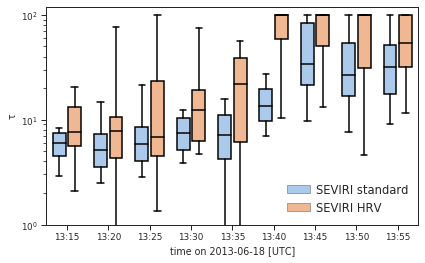

In [594]:
fig,ax = plt.subplots(1,1,figsize=(6,3.75))
# boxplot
sns.boxplot(x='time',
            y='value',
            hue='resolution',
            data=cot_df,
            fliersize=0,
            ax=ax,
            whis=100,
            **boxplot_kwargs)

# shrink boxes for some spacing between boxes of same time step
for artist in ax.artists:
    _reduce_box_width(artist, factor=shrink_factor)

horizontal_lines = [l for l in ax.lines
                    if len(l.get_path().vertices) != 0 and
                       l.get_path().vertices[0, 1] == l.get_path().vertices[1, 1]]
for line in horizontal_lines:
    _reduce_horizontal_line_width(line,shrink_factor)


# adjust legend
ax.legend_.remove()
# Fix the legend, keep only the first two legend elements
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles[0:2], labels[0:2],
               loc='lower right',
               fontsize='large',
               handletextpad=0.5, frameon = False)
lgd.legendHandles[0]._sizes = [40]
lgd.legendHandles[1]._sizes = [40]

# label and scale axes
ax.set_ylabel(u"\u03c4")
ax.set_xlabel("time on 2013-06-18 [UTC]")
ax.set_ylim(1,120)
ax.set(yscale="log")

plt.tight_layout()
plt.savefig("{}/fig_ci_cot_box.pdf".format(data_folder))

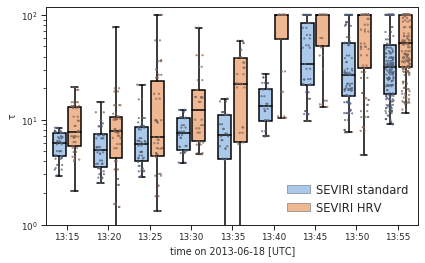

In [595]:
fig,ax = plt.subplots(1,1,figsize=(6,3.75))
# boxplot
sns.boxplot(x='time',
            y='value',
            hue='resolution',
            data=cot_df,
            fliersize=0,
            ax=ax,
            whis=100,
            **boxplot_kwargs)

# shrink boxes for some spacing between boxes of same time step
for artist in ax.artists:
    _reduce_box_width(artist, factor=shrink_factor)

horizontal_lines = [l for l in ax.lines
                    if len(l.get_path().vertices) != 0 and
                       l.get_path().vertices[0, 1] == l.get_path().vertices[1, 1]]
for line in horizontal_lines:
    _reduce_horizontal_line_width(line,shrink_factor)

# add points
sns.stripplot(x='time', y='value', hue='resolution', data=cot_df, ax=ax,
              dodge=True, jitter=0.2, **stripplot_kwargs)

# adjust legend
ax.legend_.remove()
# Fix the legend, keep only the first two legend elements
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles[0:2], labels[0:2],
               loc='lower right',
               fontsize='large',
               handletextpad=0.5, frameon = False)
lgd.legendHandles[0]._sizes = [40]
lgd.legendHandles[1]._sizes = [40]

# label and scale axes
ax.set_ylabel(u"\u03c4")
ax.set_xlabel("time on 2013-06-18 [UTC]")
ax.set_ylim(1,120)
ax.set(yscale="log")

plt.tight_layout()
plt.savefig("{}/fig_ci_cot_box+strip.pdf".format(data_folder))

In [74]:
fig,ax = plt.subplots(2,2,figsize=(12,7.5),sharex=True, sharey=True)
for i,th in enumerate([240,230]):
    for j,s in enumerate([5,7]):

        # boxplot
        sns.boxplot(x='time',
                    y='value',
                    hue='resolution',
                    data=cot_df[cot_df.masking=='{}_{:02d}'.format(th,s)],
                    fliersize=0,
                    ax=ax[i,j],
                    whis=100,
                    **boxplot_kwargs)

        # shrink boxes for some spacing between boxes of same time step
        for artist in ax[i,j].artists:
            _reduce_box_width(artist, factor=shrink_factor)

        horizontal_lines = [l for l in ax[i,j].lines
                            if len(l.get_path().vertices) != 0 and
                               l.get_path().vertices[0, 1] == l.get_path().vertices[1, 1]]
        for line in horizontal_lines:
            _reduce_horizontal_line_width(line,shrink_factor)

        # add points
        sns.stripplot(x='time',
                      y='value',
                      hue='resolution',
                      data=cot_df[cot_df.masking=='{}_{:02d}'.format(th,s)], ax=ax[i,j],
                      dodge=True, jitter=0.2, **stripplot_kwargs)

        # adjust legend
        ax[i,j].legend_.remove()
        # Fix the legend, keep only the first two legend elements
        handles, labels = ax[i,j].get_legend_handles_labels()
        lgd = ax[i,j].legend(handles[0:2], labels[0:2],
                       loc='lower right',
                       fontsize='large',
                       handletextpad=0.5, frameon = False)
        lgd.legendHandles[0]._sizes = [40]
        lgd.legendHandles[1]._sizes = [40]

        # label and scale axes
        if j == 0:
            ax[i,j].set_ylabel(u"\u03c4")
        else:
            ax[i,j].set_ylabel("")
        if i == 1:
            ax[i,j].set_xlabel("time on 2013-06-18 [UTC]")
        else:
            ax[i,j].set_xlabel("")
        ax[i,j].set_ylim(1,120)
        ax[i,j].set(yscale="log")
        ax[i,j].set_title("Tthresh. = {} K, spread = {} K".format(th,s))

plt.tight_layout()
plt.savefig("{}/fig_ci_cot_box+strip_variants.pdf".format(data_folder))

plt.close()

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(6,3.75))
# boxplot
sns.boxplot(x='time',
            y='value',
            hue='resolution',
            data=cot_df,
            fliersize=0,
            ax=ax,
            whis=100,
            **boxplot_kwargs)

# shrink boxes for some spacing between boxes of same time step
for artist in ax.artists:
    _reduce_box_width(artist, factor=shrink_factor)

horizontal_lines = [l for l in ax.lines
                    if len(l.get_path().vertices) != 0 and
                       l.get_path().vertices[0, 1] == l.get_path().vertices[1, 1]]
for line in horizontal_lines:
    _reduce_horizontal_line_width(line,shrink_factor)

# add points
sns.stripplot(x='time', y='value', hue='resolution', data=cot_df[cot_df.masking=='240_07'], ax=ax,
              dodge=True, jitter=0.2, **stripplot_kwargs)

# adjust legend
ax.legend_.remove()
# Fix the legend, keep only the first two legend elements
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles[0:2], labels[0:2],
               loc='lower right',
               fontsize='large',
               handletextpad=0.5, frameon = False)
lgd.legendHandles[0]._sizes = [40]
lgd.legendHandles[1]._sizes = [40]

# label and scale axes
ax.set_ylabel(u"\u03c4")
ax.set_xlabel("time on 2013-06-18 [UTC]")
ax.set_ylim(1,120)
ax.set(yscale="log")

plt.tight_layout()
plt.savefig("{}/fig_ci_cot_box+strip_240_07.pdf".format(data_folder))

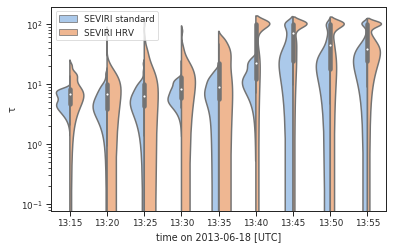

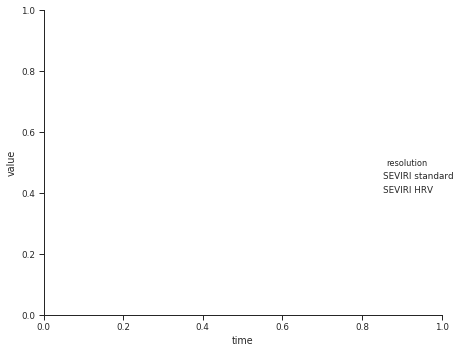

In [596]:
fig,ax = plt.subplots(1,1,figsize=(6,3.75))
sns.catplot(x='time',
            y='value',
            hue='resolution',
            data=cot_df,
            palette='pastel',
            kind='violin',
            split=True,
            ax=ax, 
            width=0.75,
            edgecolor= 'k',
            linewidth= 1.5,
            scale='width')
ax.legend_.remove()
ax.set_ylabel(u"\u03c4")
ax.set_xlabel("time on 2013-06-18 [UTC]")
ax.set(yscale="log")
ax.legend(title=None)

for artist in ax.artists:
    _reduce_box_width(artist, factor=.1)

horizontal_lines = [l for l in ax.lines
                    if len(l.get_path().vertices) != 0 and
                       l.get_path().vertices[0, 1] == l.get_path().vertices[1, 1]]
for line in horizontal_lines:
    _reduce_horizontal_line_width(line,0.1)


plt.tight_layout()
plt.savefig("{}/fig_ci_cot.pdf".format(data_folder))

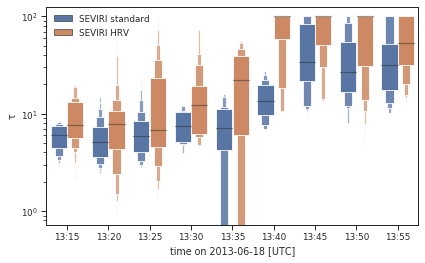

In [597]:
fig,ax = plt.subplots(1,1,figsize=(6,3.75))
sns.boxenplot(x='time',
            y='value',
            hue='resolution',
            data=cot_df,
            palette='deep',
            linewidth= 1.5,ax=ax)
ax.set_ylabel(u"\u03c4")
ax.set_xlabel("time on 2013-06-18 [UTC]")
ax.set(yscale="log")
ax.legend(title=None, frameon=False)

plt.tight_layout()
plt.savefig("{}/fig_ci_cot_boxen.pdf".format(data_folder))

## Objektgröße

In [598]:
times, area = np.unique(ir108_df.time,return_counts=True)

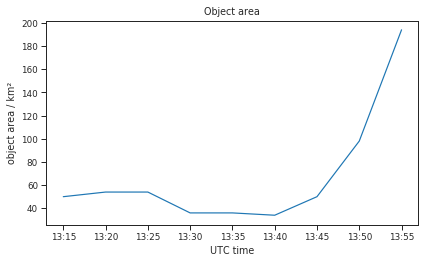

In [599]:
fig,ax = plt.subplots(1,1,figsize=(6,3.75))
ax.plot(times,area)
ax.set_xlabel("UTC time")
ax.set_title("Object area")
ax.set_ylabel(u"object area / km\u00b2")
plt.tight_layout()
plt.savefig("{}/object_area.pdf".format(data_folder))

Text(0, 0.5, 'BT 10.8 µm / K')

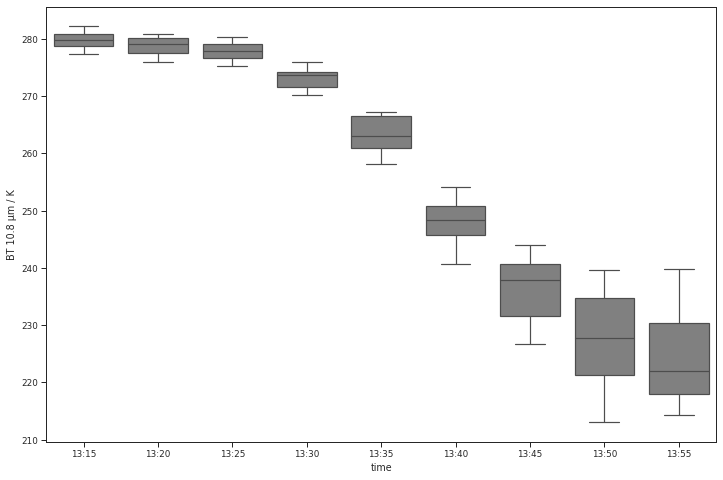

In [600]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
sns.boxplot(x='time',y='value',data=ir108_df,ax=ax,color='gray')
ax.set_ylabel("BT 10.8 µm / K")

## Startpunktkoordinaten

In [ ]:
from io_tools import radolan

In [ ]:
r =radolan.Radolan()

In [ ]:
haci_data = pd.read_csv("/vols/satellite/home/lenk/data/HACI_bbox_data/haci_cases_2013.csv")

In [ ]:
cases_day = haci_data[(haci_data.date=="2013-06-18") & (haci_data.time=="13:50") & (haci_data.t1- haci_data.t0 >= 6)]

In [ ]:
def haci_coords2geo_coords(object_data,rlon,rlat):
    l = object_data.l0 + (object_data.l1 - object_data.l0) // 2
    c = object_data.c0 + (object_data.c1 - object_data.c0) // 2
    
    return (rlon[l,c],rlat[l,c])

In [54]:
def decdeg2dms(dd):
    is_positive = dd >= 0
    dd = abs(dd)
    minutes,seconds = divmod(dd*3600,60)
    degrees,minutes = divmod(minutes,60)
    degrees = degrees if is_positive else -degrees
    return (degrees,minutes,seconds)

In [73]:
def dms2decdeg(d,m,s):
    dec = m / 60 + s / 3600
    return (d + dec)

In [74]:
decdeg2dms(-15.1)

(-15.0, 6.0, 0.0)

In [75]:
decdeg2dms(dms2decdeg(9,20,0) + 8.5)

(17.0, 50.0, 7.275957614183426e-12)

In [78]:
decdeg2dms(dms2decdeg(16,15,0) - 8.5)

(7.0, 45.0, 0.0)

In [ ]:
for i,case in cases_day.iterrows():
    lo,la = haci_coords2geo_coords(case,r.lon,r.lat)
    lo_d,lo_m,lo_s = decdeg2dms(lo)
    la_d,la_m,la_s = decdeg2dms(la)
    print(u"lon = {:.0f}°{:.0f}\'{:.0f}\"\nlat= {:.0f}°{:.0f}\'{:.0f}\"".format(lo_d,lo_m,lo_s,la_d,la_m,la_s))